# Data Preprocessing

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import json
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from utils.mal_data import get_mal_data

### Settings and parameters

In [2]:
with open ('../settings.json') as f:
    settings = json.load(f)

DATA_DIR = os.path.join(settings['data_path'], 'classifier')
os.makedirs(DATA_DIR, exist_ok=True)
REPORTS_DIR = os.path.join(DATA_DIR, 'report_data')
os.makedirs(REPORTS_DIR, exist_ok=True)

SIGNATURES = ['wmi', 'com', 'cmd', 'benign']


### Get Data

In [3]:

# get_mal_data returns a list of reports preporcessed at the word level. At this point, the reports are not completely 
# tokenized but have been cleaned up and are ready to be tokenized.
reports = get_mal_data(SIGNATURES)

Loading wmi reports from file
Loading com reports from file
Loading cmd reports from file
Loading benign reports from file


In [4]:
len(reports)

17299

### Prune long and short reports

In [5]:
# count the average, min, and max length of reports per signature
for signature in SIGNATURES:
    lengths = []
    for report in reports:
        if report[1] == signature:
            lengths.append(len(report[0]))
    avg_length = np.mean(lengths)
    min_length = np.min(lengths)
    max_length = np.max(lengths)
    print(f'Average length of {signature} reports: {avg_length:.2f} words')
    print(f'Minimum length of {signature} reports: {min_length} words')
    print(f'Maximum length of {signature} reports: {max_length} words')
    # count number of reports with length less than 1000 words
    short_reports = sum(1 for length in lengths if length < 1000)
    print(f'Number of {signature} reports with less than 1000 words: {short_reports}')
    # count number of reports with length greater than 10000 words
    long_reports = sum(1 for length in lengths if length > 10000)
    print(f'Number of {signature} reports with more than 10000 words: {long_reports}')
    print('---')
    

Average length of wmi reports: 9950.14 words
Minimum length of wmi reports: 0 words
Maximum length of wmi reports: 10068 words
Number of wmi reports with less than 1000 words: 1
Number of wmi reports with more than 10000 words: 23
---
Average length of com reports: 2903.69 words
Minimum length of com reports: 2895 words
Maximum length of com reports: 2931 words
Number of com reports with less than 1000 words: 0
Number of com reports with more than 10000 words: 0
---
Average length of cmd reports: 1706.20 words
Minimum length of cmd reports: 1671 words
Maximum length of cmd reports: 1717 words
Number of cmd reports with less than 1000 words: 0
Number of cmd reports with more than 10000 words: 0
---
Average length of benign reports: 11823.08 words
Minimum length of benign reports: 337 words
Maximum length of benign reports: 6288865 words
Number of benign reports with less than 1000 words: 2459
Number of benign reports with more than 10000 words: 1290
---


In [6]:
# print the number of reports per signature before pruning
for signature in SIGNATURES:
    count = sum(1 for report in reports if report[1] == signature)
    print(f'Before pruning {signature}: {count} reports')

# prune long and short reports
for signature in SIGNATURES:
    for report in reports:
        if len(report[0]) < 1_000:
            reports.remove(report)
        if len(report[0]) > 10_000:
            reports.remove(report)

# print the number of reports per signature after pruning
for signature in SIGNATURES:
    count = sum(1 for report in reports if report[1] == signature)
    print(f'After pruning {signature}: {count} reports')

Before pruning wmi: 2028 reports
Before pruning com: 2001 reports
Before pruning cmd: 2001 reports
Before pruning benign: 11269 reports
After pruning wmi: 2004 reports
After pruning com: 2001 reports
After pruning cmd: 2001 reports
After pruning benign: 7520 reports


### Data Discovery and Cleaning

Number ofreports for wmi: 2004
Mean report length for wmi: 9954.190119760478
Median report length for wmi: 9952.0
Min report length for wmi: 9926
Max report length for wmi: 9997
Standard deviation for wmi: 12.172548636379265
Number of outliers: 429


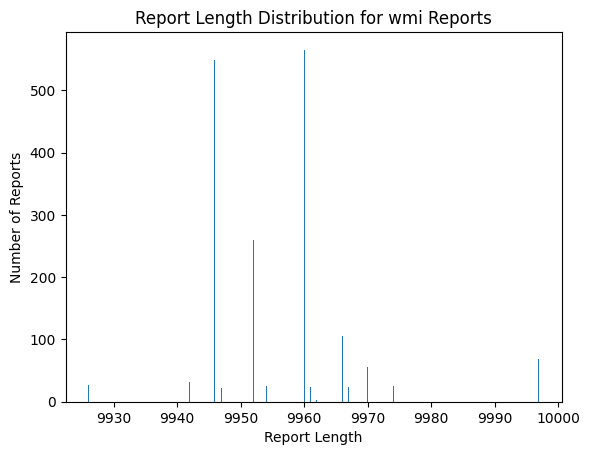

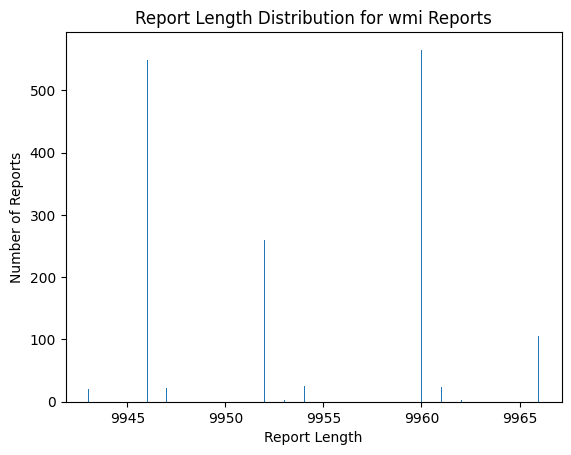

Number ofreports for com: 2001
Mean report length for com: 2903.685157421289
Median report length for com: 2901.0
Min report length for com: 2895
Max report length for com: 2931
Standard deviation for com: 6.190853031455164
Number of outliers: 128


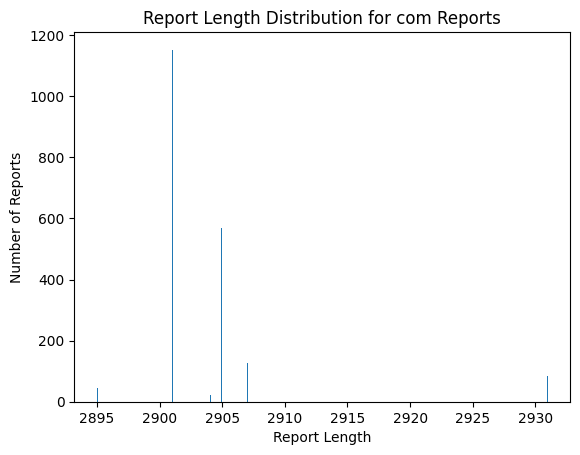

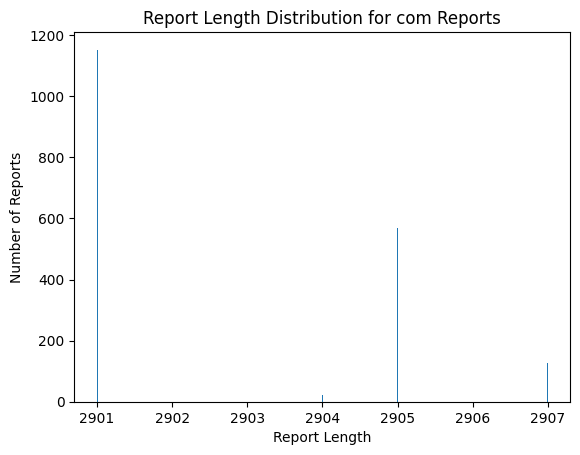

Number ofreports for cmd: 2001
Mean report length for cmd: 1706.1964017991004
Median report length for cmd: 1707.0
Min report length for cmd: 1671
Max report length for cmd: 1717
Standard deviation for cmd: 9.835930778494586
Number of outliers: 158


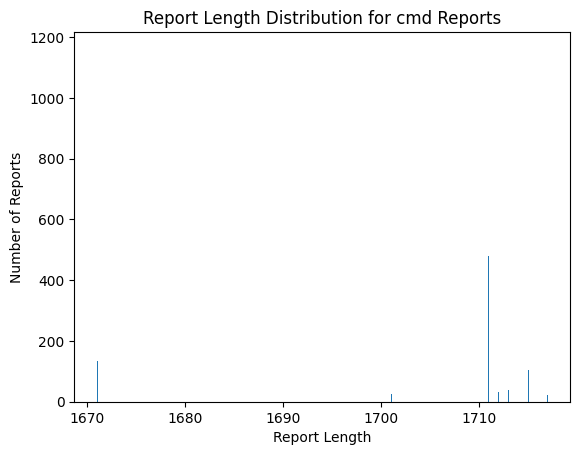

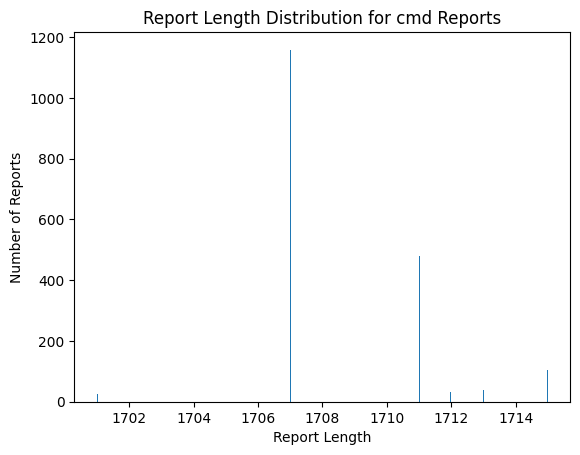

Number ofreports for benign: 7515
Mean report length for benign: 3334.3431803060544
Median report length for benign: 2731.0
Min report length for benign: 1000
Max report length for benign: 9996
Standard deviation for benign: 2069.494393140167
Number of outliers: 2061


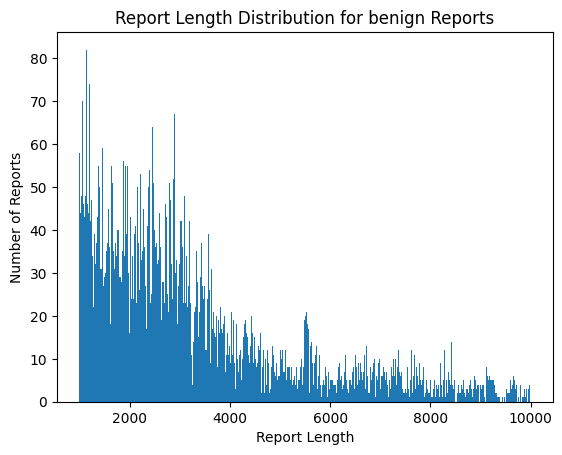

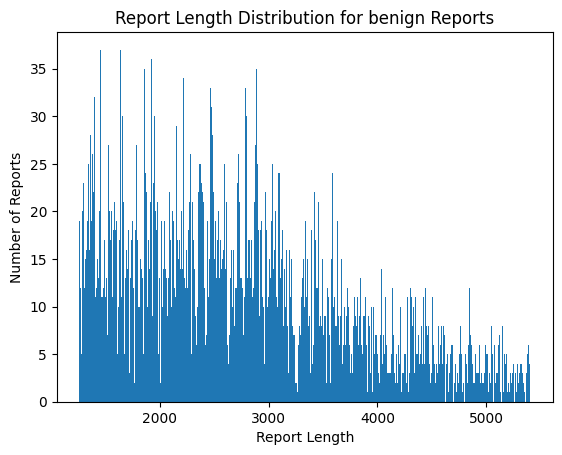

In [7]:
std_thres = 1

# find the mean, median, min, and max lengths of the reports for each signature
for signature in SIGNATURES:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    mean_length = np.mean(report_lengths)
    median_length = np.median(report_lengths)
    min_length = min(report_lengths)
    max_length = max(report_lengths)
    std_dev = np.std(report_lengths)

    print(f"Number ofreports for {signature}: {len(report_lengths)}")
    print(f"Mean report length for {signature}: {mean_length}")
    print(f"Median report length for {signature}: {median_length}")
    print(f"Min report length for {signature}: {min_length}")
    print(f"Max report length for {signature}: {max_length}")
    print(f"Standard deviation for {signature}: {std_dev}")

    # find the outliers in the report lengths based on standard deviation

    outliers = [r for r in report_lengths if (r > mean_length + (std_thres * std_dev) or r < mean_length - (std_thres * std_dev))]
    print(f"Number of outliers: {len(outliers)}")

    # graph distribution of the report lengths before removing outliers
    plt.hist(report_lengths, bins=500)
    plt.xlabel('Report Length')
    plt.ylabel('Number of Reports')
    plt.title(f'Report Length Distribution for {signature} Reports')
    plt.show()

    # remove outliers
    reports = [r for r in reports if len(r[0]) not in outliers]
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]

    # graph distribution of the report lengths after removing outliers
    plt.hist(report_lengths, bins=500)
    plt.xlabel('Report Length')
    plt.ylabel('Number of Reports')
    plt.title(f'Report Length Distribution for {signature} Reports')
    plt.show()

### Select 4,000 reports for training

In [8]:
# print the number of reports for each signature after removing outliers
for signature in SIGNATURES:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    print(f"Number of reports for {signature}: {len(report_lengths)}")

# randomly shuffle and select at most 4000 of each signature
selected_reports = []
for signature in SIGNATURES:
    selected_reports.extend([r for r in reports if r[1] == signature][:4000])
reports = selected_reports
random.shuffle(reports)

# print the number of reports for each signature after selecting 4000 of each
for signature in SIGNATURES:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    print(f"Number of reports for {signature}: {len(report_lengths)}")

print(f"Total number of reports: {len(reports)}")

Number of reports for wmi: 1575
Number of reports for com: 1873
Number of reports for cmd: 1843
Number of reports for benign: 5454
Number of reports for wmi: 1575
Number of reports for com: 1873
Number of reports for cmd: 1843
Number of reports for benign: 4000
Total number of reports: 9291


### Save clean and selected data

In [9]:
def sign_to_idx(signature):
    if signature in SIGNATURES:
        return SIGNATURES.index(signature)
    else:
        return -1

In [10]:
json_data = []

# make sure that REPORTS_DIR exists
os.makedirs(REPORTS_DIR, exist_ok=True)

file_count = 0
for report in tqdm(reports, desc="Processing reports"):
    text = " ".join(report[0])
    label = sign_to_idx(report[1])

    # add to json_data
    json_data.append({"text": text, "label": label})

    # write to file every 1000 lines
    if len(json_data) == 1000:
        with open(os.path.join(REPORTS_DIR, f"json_{file_count}.json"), 'w') as f:
            for line in json_data:
                json.dump(line, f)
                f.write("\n")
        json_data = []
        file_count += 1
    
# save last file
if len(json_data) > 0:
    with open(os.path.join(REPORTS_DIR, f"json_{file_count}.json"), 'w') as f:
        for line in json_data:
            json.dump(line, f)
            f.write("\n")
    json_data = []
    file_count += 1

Processing reports: 100%|██████████| 9291/9291 [00:01<00:00, 6107.06it/s]


In [11]:
# spot check: load one of the json files and print the first 5 entries
with open(os.path.join(REPORTS_DIR, "json_3.json"), 'r') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        line = json.loads(line)
        print(line['text'][1000:1100], line['label'])

 hklm system currentcontrolset control session manager success createfile c: users admin gimc sandbo 2
 hklm system currentcontrolset control session manager success createfile c: users admin gimc sandbo 1
 hklm system currentcontrolset control session manager success createfile c: users admin gimc sandbo 1
 hklm system currentcontrolset control session manager success createfile c: users admin gimc sandbo 3
 hklm system currentcontrolset control session manager success createfile c: users admin gimc sandbo 1


In [12]:
# count the total of labels in each file (sanity check)
total_label_counts = {i: 0 for i in range(len(SIGNATURES))}
for i in range(10):
    label_counts = {}
    with open(os.path.join(REPORTS_DIR, f"json_{i}.json"), 'r') as f:
        for line in f:
            line = json.loads(line)
            label = line['label']
            label_counts[label] = label_counts.get(label, 0) + 1
    print(f"File json_{i}.json label counts: {label_counts}")
    for label, count in label_counts.items():
        total_label_counts[label] += count
print(f"Total label counts across all files: {total_label_counts}")

File json_0.json label counts: {2: 205, 0: 171, 3: 426, 1: 198}
File json_1.json label counts: {3: 421, 2: 189, 1: 232, 0: 158}
File json_2.json label counts: {3: 430, 1: 193, 2: 203, 0: 174}
File json_3.json label counts: {2: 193, 1: 203, 3: 443, 0: 161}
File json_4.json label counts: {3: 436, 1: 194, 0: 174, 2: 196}
File json_5.json label counts: {3: 411, 2: 194, 1: 206, 0: 189}
File json_6.json label counts: {3: 446, 2: 193, 0: 170, 1: 191}
File json_7.json label counts: {2: 206, 3: 429, 1: 179, 0: 186}
File json_8.json label counts: {3: 420, 0: 155, 2: 200, 1: 225}
File json_9.json label counts: {3: 138, 2: 64, 1: 52, 0: 37}
Total label counts across all files: {0: 1575, 1: 1873, 2: 1843, 3: 4000}
